In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
import time, os, copy, sys
import numpy as np
!pip install livelossplot
from livelossplot import PlotLosses
%matplotlib inline

In [2]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()
    #liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)), end="")

#                 print( (i+1)*100. / len(dataloaders[phase]), "% Complete" )
                sys.stdout.flush()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"running_corrects: {running_corrects.double()} and dateset_size {dataset_sizes[phase]}")
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        '''
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })

        liveloss.draw()
        '''
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
data_dir = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths


--2024-03-08 13:16:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  23.9MB/s    in 10s     

2024-03-08 13:16:55 (22.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
#print current folder
print(os.getcwd())

In [4]:
import shutil
def correct_file_structure():
    root = "tiny-imagenet-200"
    annotations_file = "tiny-imagenet-200/val/val_annotations.txt"
    output_folder = os.path.join(root, "val2")
    image_path = "tiny-imagenet-200/val/images"

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read annotations file
    with open(annotations_file) as f:
        annotations = f.readlines()

    # Process annotations
    for i,annotation in enumerate(annotations):
        #print(f"Working on Image {i}")
        parts = annotation.strip().split("\t")
        image_name = parts[0]
        class_name = parts[1]

        # Create subdirectory for the class if it doesn't exist
        class_folder = os.path.join(output_folder, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        # Copy image to the class folder
        shutil.copy(os.path.join(image_path, image_name), os.path.join(class_folder, image_name))


In [5]:
correct_file_structure()
#change names from val to val_old and val2 to val

In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

#data_dir = '../../Code Masterarbeit/Masterthesis/data/ImageNet/tiny-imagenet-200'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=64)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


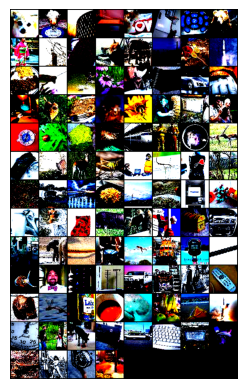

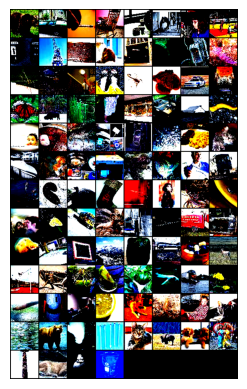

In [7]:
def show_example_image(loader, classes, batch_size):
    # get some random training images
    dataiter = iter(loader)
    images, labels = next(dataiter)

    ##make grid of images
    grid_img = torchvision.utils.make_grid(images)

    # Display the grid of images using imshow
    plt.imshow(grid_img.permute(1, 2, 0))  # permute dimensions for displaying with plt.imshow
    #plt.title(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.axis('off')  # Turn off axis
    plt.show()

show_example_image(dataloaders["train"], None, None)
show_example_image(dataloaders["val"], None, None)

In [8]:
#Load Resnet18
model_ft = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)
model_ft = model_ft.to(device)
#Multi GPU
model_ft = torch.nn.DataParallel(model_ft)#, device_ids=[0, 1])

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

device cuda:0


In [ ]:
#Train
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

In [10]:
torch.save(model_ft.state_dict(), "resnet18_baseline.pth")

## ResNet_224

In [8]:
#Load Resnet18 with pretrained weights
model_ft = models.resnet18(pretrained=True)
#Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
#Multi GPU
model_ft = torch.nn.DataParallel(model_ft)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 56.4MB/s]


In [9]:
#Train
model_ft = train_model(model_ft, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 1/15
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Iteration: 1000/1000, Loss: 253.0806303024292.running_corrects: 28819.0 and dateset_size 100000
Iteration: 100/100, Loss: 272.0560550689697.running_corrects: 4417.0 and dateset_size 10000
Train Loss: 3.3668 Acc: 0.2882
Val Loss: 2.3566 Acc: 0.4417
Best Val Accuracy: 0.44170000000000004

Epoch 2/15
----------
Iteration: 1000/1000, Loss: 252.06382274627686.running_corrects: 49817.0 and dateset_size 100000
Iteration: 100/100, Loss: 191.6059970855713.running_corrects: 5069.0 and dateset_size 10000
Train Loss: 2.0682 Acc: 0.4982
Val Loss: 2.0379 Acc: 0.5069
Best Val Accuracy: 0.5069

Epoch 3/15
----------
Iteration: 1000/1000, Loss: 157.5205683708191.running_corrects: 58190.0 and dateset_size 100000
Iteration: 100/100, Loss: 190.38841724395752.running_corrects: 5295.0 and dateset_size 10000
Train Loss: 1.6710 Acc: 0.5819
Val Loss: 1.9254 Acc: 0.5295
Best Val Accuracy: 0.5295

Epoch 4/15
----------
Iteration: 1000/1000, Loss: 139.96942043304443.running_corrects: 64961.0 and dateset_size 1000

In [10]:
#torch.save(model_ft.state_dict(), "./models/resnet18_224_w.pt")
torch.save(model_ft.state_dict(), "resnet18_224_w.pth")
# torch.save(model_ft, "./models/resnet18_224_f.pt")

## ResNet18_224 FineTuning


In [11]:
#Load Resnet18 with pretrained weights
model_final = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
model_final.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_final.fc.in_features
model_final.fc = nn.Linear(num_ftrs, 200)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_final = model_final.to(device)
#Multi GPU
model_final = torch.nn.DataParallel(model_final)
model_final.load_state_dict(torch.load('resnet18_224_w.pth'))


#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_final = optim.SGD(model_final.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_final, step_size=7, gamma=0.1)

In [12]:
model_final = train_model(model_final, dataloaders, dataset_sizes, criterion, optimizer_final, exp_lr_scheduler,
                       num_epochs=7)

Epoch 1/7
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.wa

Iteration: 1000/1000, Loss: 73.76719117164612.running_corrects: 85205.0 and dateset_size 100000
Iteration: 100/100, Loss: 253.02705764770508.running_corrects: 5296.0 and dateset_size 10000
Train Loss: 0.6165 Acc: 0.8521
Val Loss: 2.0245 Acc: 0.5296
Best Val Accuracy: 0.5296000000000001

Epoch 2/7
----------
Iteration: 1000/1000, Loss: 50.258272886276245.running_corrects: 89594.0 and dateset_size 100000
Iteration: 100/100, Loss: 197.06311225891113.running_corrects: 5331.0 and dateset_size 10000
Train Loss: 0.4616 Acc: 0.8959
Val Loss: 2.0555 Acc: 0.5331
Best Val Accuracy: 0.5331

Epoch 3/7
----------
Iteration: 1000/1000, Loss: 36.23524606227875.running_corrects: 93405.0 and dateset_size 100000
Iteration: 100/100, Loss: 249.28343296051025.running_corrects: 5264.0 and dateset_size 10000
Train Loss: 0.3306 Acc: 0.9341
Val Loss: 2.1242 Acc: 0.5264
Best Val Accuracy: 0.5331

Epoch 4/7
----------
Iteration: 1000/1000, Loss: 37.542325258255005.running_corrects: 96167.0 and dateset_size 100000

In [13]:
torch.save(model_final.state_dict(), "resnet18_256_64.pth")

#### get correct size

In [14]:
#Load Resnet18 with pretrained weights
model_final2 = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
model_final2.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = model_final2.fc.in_features
model_final2.fc = nn.Linear(num_ftrs, 200)
model_final2.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
model_final2.maxpool = nn.Sequential()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_final2 = model_final2.to(device)

#Multi GPU
#model_final2 = torch.nn.DataParallel(model_final2)
# Try to train normal and save the model then

pretrained_dict = torch.load('resnet18_256_64.pth')
model_final2_dict = model_final2.state_dict()
first_layer_weight = model_final2_dict['module.conv1.weight']
first_layer_bias  = model_final2_dict['module.conv1.bias']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_final2_dict}

model_final2_dict.update(pretrained_dict)
model_final2_dict['module.conv1.weight'] = first_layer_weight
model_final2_dict['module.conv1.bias']   = first_layer_bias
model_final2.load_state_dict(model_final2_dict)


#Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_final2 = optim.SGD(model_final2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_final2, step_size=7, gamma=0.1)

In [23]:
model_final2 = train_model(model_final2, dataloaders, dataset_sizes, criterion, optimizer_final2, exp_lr_scheduler,
                       num_epochs=7)

Epoch 1/7
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.wa

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
#torch.save(model_final2.state_dict(), "resnet18_64_final_parallel.pth")

In [ ]:
#torch.save(model_final2.state_dict(), "resnet18_64_final_on_GPU.pth")

In [15]:
new_device = torch.device("cpu")
model_final2 = model_final2.to(new_device)

#model_final2 = train_model(model_final2, dataloaders, dataset_sizes, criterion, optimizer_final2, exp_lr_scheduler,num_epochs=2)

if isinstance (model_final2, torch.nn.DataParallel):
  model_final2 = model_final2.module




In [16]:
def get_accuracy_per_class(net, testloader, classes):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    accuracies= []
    correct = 0
    total = 0

    print("len of dataset: ", len(testloader.dataset))
    print("len with batches", len(testloader))

    # again no gradients needed
    with torch.no_grad(): #context manager, deactivates gradient compuation during a code block
        for i, data in enumerate(testloader,0):
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

            if i % 200 == 199:    # print every 2000 mini-batches
             print(f'Current Sample: {i+1},  currente accuracy { 100 * correct // total} %' )
             print(f"labels {labels} and predictions {predictions}")


    #total accuracy
    total_accuracy = 100 * correct // total
    print(f'Accuracy of the network on the {total} test images: {total_accuracy} %')

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 0 if total_pred[classname] == 0 else 100 * float(correct_count) / total_pred[classname]
        accuracies.append({classname: accuracy})
        print(f'Accuracy for class [{total_pred[classname]} images]: {classname:5s} is {accuracy:.1f} %')

    return total_accuracy, accuracies

In [ ]:
get_accuracy_per_class(model_final2, dataloaders['val'], dataloaders['val'].dataset.classes)

In [17]:
torch.save(model_final2.state_dict(), "resnet18_64_final.pth")

Test

In [18]:
net = models.resnet18()
#Finetune Final few layers to adjust for tiny imagenet input
net.avgpool = nn.AdaptiveAvgPool2d(1)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 200)
net.conv1 = nn.Conv2d(3,64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
net.maxpool = nn.Sequential()
net.load_state_dict(torch.load("resnet18_64_final.pth")) #, map_location=torch.device('cpu')))
'''
print("Before loading:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())




# After loading
print("############"*10)
print("\nAfter loading:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

'''


print("############"*10)
print(net.state_dict() == model_final2.state_dict)

Before loading:
conv1.weight 	 torch.Size([64, 3, 3, 3])
conv1.bias 	 torch.Size([64])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.1.conv1.weight 	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight 	 torch.Size([64])
layer1.1.bn1.bias 	 torch.Size([64])
layer1.1.bn1.running_mean 	 torch.Size([64])
layer1.1.bn1.running_var 	 torch.Size([

In [22]:
print(net.state_dict() == model_final2.state_dict())

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
get_accuracy_per_class(net, dataloaders['val'], dataloaders['val'].dataset.classes)